In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Significance of Virgo SNR peak of GW170814

**Goal: To estimate the significance of signal-to-noise ratio peak observed in the Virgo instrument near in time to the large peaks observed in the LIGO-Hanford and LIGO-Livingston observatories.<br>Question: What is the probability that noise can produce a peak as large or larger than the largest peak observed in the Virgo data, within a consistent lightspeed travel between all three observations? This is a form of null hypothesis testing, where we create a p-value.<br><br>We may a few additional simplifying assumptions, and those will be stated as we go along.**

# Reading and preconditioning gravitational strain data

### Assumption 1: Here that the power spectral estimate of the data is constant over this short stretch of time, and isn't biased by the fact that we chose to center the estimate (very roughly) on the event time. We do not assume that the data is actually stationary, Gaussian, or is free from non-astrophysical transient artefacts.

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


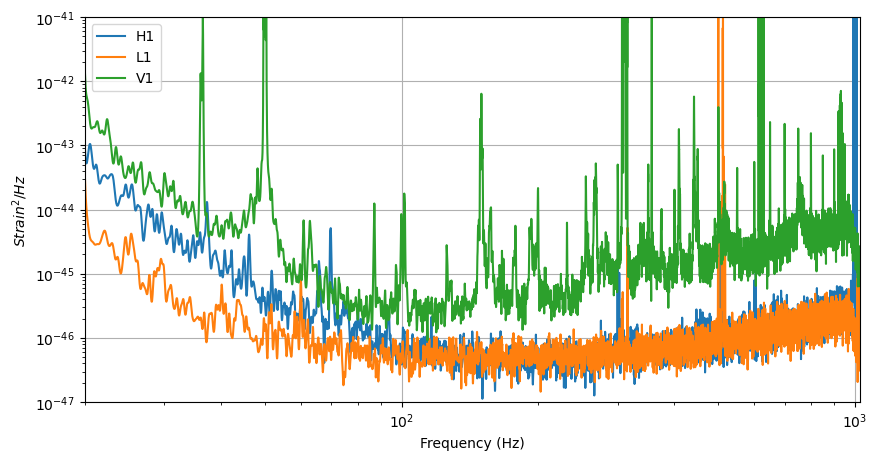

In [2]:
%matplotlib inline

import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

m = Merger("GW170814")

ifos = ['H1', 'L1', 'V1']
data = {}
psd = {}

pylab.figure(figsize=[10, 5])

for ifo in ifos:
    
    # Read in and precondition the data
    ts = m.strain(ifo).highpass_fir(15, 512)
    data[ifo] = resample_to_delta_t(ts, 1/2048).crop(2, 2)
    
    # Estimating the power spectral density (PSD) of the data
    p = data[ifo].psd(4)
    p = interpolate(p, data[ifo].delta_f)
    p = inverse_spectrum_truncation(p, int(4 * data[ifo].sample_rate), low_frequency_cutoff = 20.0)
    psd[ifo] = p
    
    pylab.plot(psd[ifo].sample_frequencies, psd[ifo], label = ifo)
    
pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-41)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

# Generate our template waveform and calculate the Signal-to-noise time series

**Assumption: The souce black holes are non spinning, have equal masses, and the agree with the total mass estimate for the system as a whole.**

In [3]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q


# Calculate the component mass of each black hole in the detector frame
mchirp = m.median1d("mchirp") # This is the source frame
zfac = (1 + m.median1d("redshift")) # Apply redshift to get the detector frame
mchirp *= zfac
mass1 = mass2 = mass1_from_mchirp_q(mchirp, 1)

# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used in prior tutorials. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = mass1, mass2 = mass2, f_lower = 20.0, delta_f = data[ifo].delta_f)

hp.resize(len(psd[ifo]))

# For each observatory, use this template to calculate the SNR time series
snr = {}
for ifo in ifos:
    snr[ifo] = matched_filter(hp, data[ifo], psd = psd[ifo], low_frequency_cutoff = 25)
    snr[ifo] = snr[ifo].crop(5, 4)

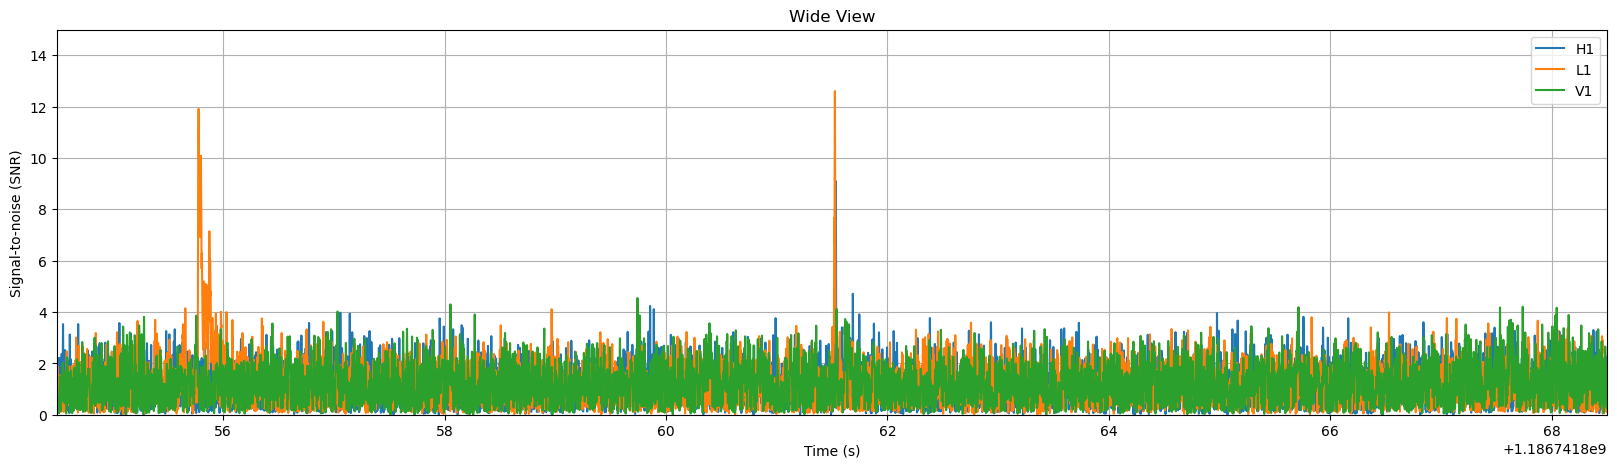

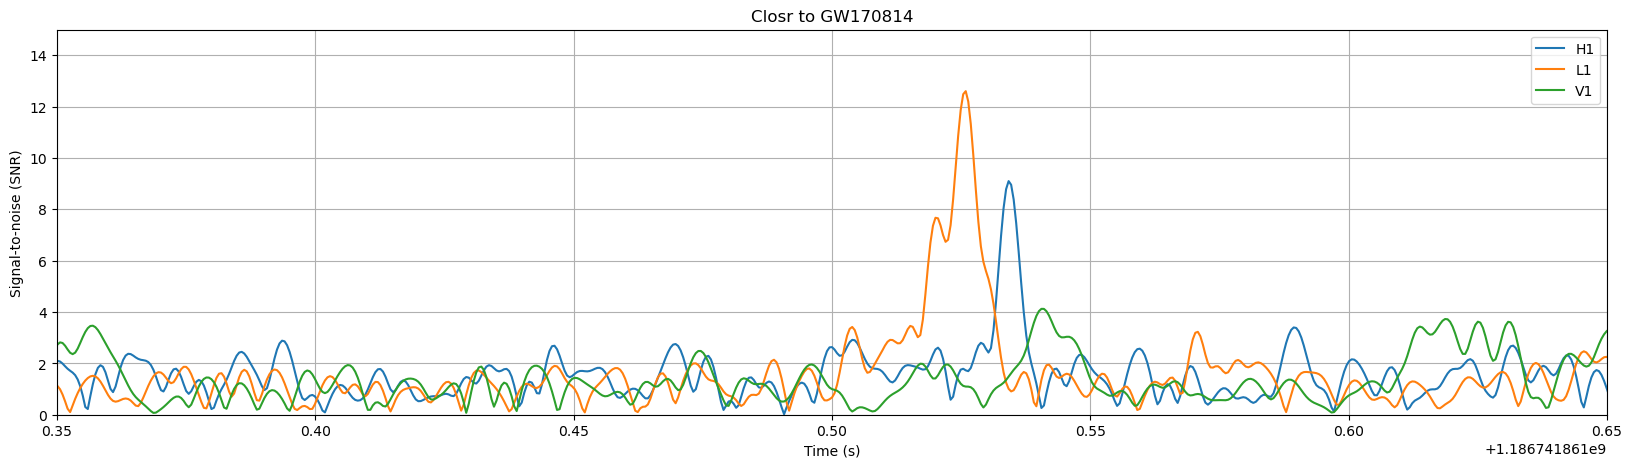

In [4]:
# Show a couple sizes
for w , title in [(7, 'Wide View'), (.15, 'Closr to GW170814')]:
    pylab.figure(figsize = (20, 5))
    
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, abs(snr[ifo]), label = ifo)
        
    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

**SNR time plots shows that, there are nice peaks around GW170814 in each detector, there are also some large peaks at the other times.<br>LIGO/Virgo data, does contain transient (i.e., limimted duration) noise artefacts that an analyses must deal with to search LIGO data with high sensitivity.**

# How well is the data actually fitting our model?

**One of the ways we can test how well the data actual fits the models is to use a chi-squared based signal consistency test.<br>Procedure: We chop up the template into p number of bins and see how much each contributes to the SNR (p_i). We can calculate our statistic as the difference between the SNR in one bin, and the expected fraction of total SNR.**

**This will have  2p−2  degrees of freedom as each SNR is complex representing both possible orthogonal phases the signal could have contributions from. There is also a constraint due to the fact that the sum of each bin must each the total SNR by definition. In this notebook we will normalize this statistic by dividing by the number of degrees of freedom, producing  χ2r .**

**We expect that this statistic will be high when the template does not match well the data, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.**

In [5]:
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    
    # The number of bins to use. In principle, this choice is arbitrary. In practice, this is emprically tuned.
    nbins = 26
    
    # power_chisq() returns a chisq timeseries
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff = 20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)
    
    dof = nbins*2 - 2
    chisq[ifo] /= dof

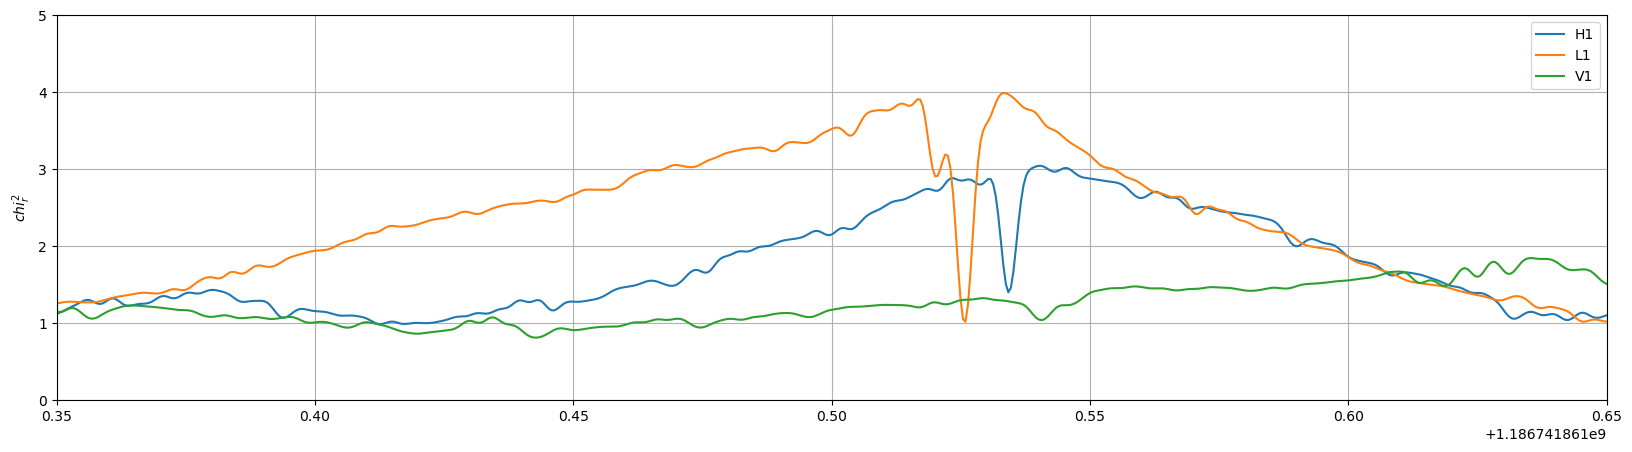

In [6]:
pylab.figure(figsize = (20, 5))

for ifo in ifos:
    pylab.plot(chisq[ifo].sample_times, chisq[ifo], label = ifo)
    
pylab.legend()
pylab.grid()
pylab.xlim(m.time -0.15, m.time + 0.15)
pylab.ylim(0, 5)
pylab.ylabel('$chi^2_r$')
pylab.show()

**We see a dip in the value at the time of the peak in the SNR in each observatory.<br>We expect this as the template now aligns with the signal in the data.<br>Also, the values climb just around this minima.<br>This occurs because the template is starting to slide against the true signal in the data but is not perfectly aligned with it.**

# Re-weighting our SNR to help down-weight times that don't fit our signal

**Our approach is, we can take down-weight the times where the data does not appear as either Gaussian noise or Gaussian noise + our template.<br> We can do this be combining the SNR time series and our  χ2r  time series as follows. This is a method used to re-weight SNR since initial LIGO, and has been employed in the first two Advanced LIGO observing runs. In this tutorial we will choose to rank our events by this statistic.**

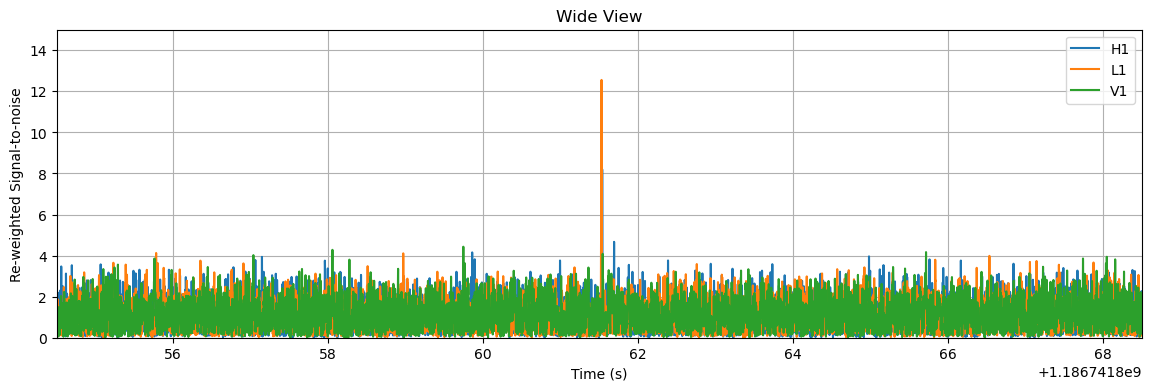

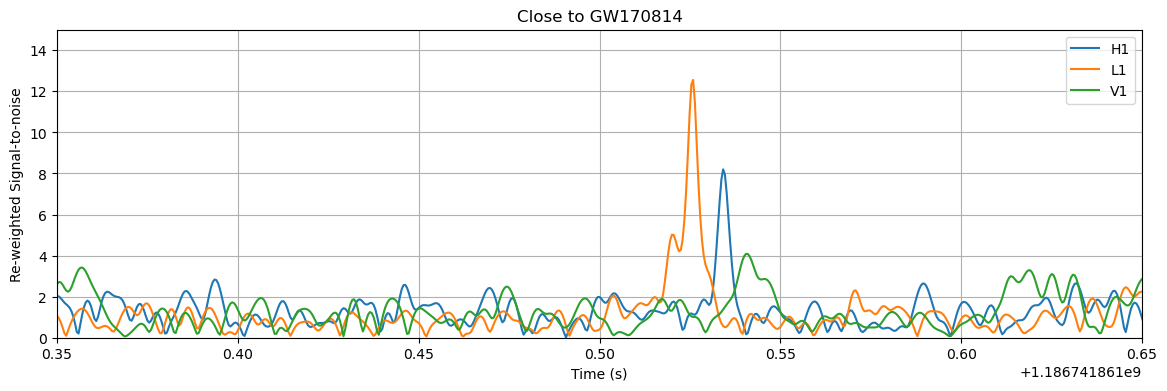

In [11]:
from pycbc.events.ranking import newsnr

# The rho_hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos} # Creates a dict

# Show a couple sizes
for w, title in [(7, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

**We can see above that there are still peaks around GW170814 in all detectors, at roughly the same signal strength, but that at other times, where that had been peaks in the time series, there are no longer large statistic values.**

# Calculating the background and significance

**In this section we will determine how significant the peak in the virgo re-weighted SNR time series is.**

**1. We will do this first by determining where one might expect a peak relative to the LIGO observed peaks. The "pycbc.detector.Detector" class provides some convenient methods to ask these sort of questions.<br>NOTE: This is set by the constraint that an astrophysical source can only cause delays between observatories no larger than the light travel time between them<br>2. We will then calculate the peak in the SNR for this window around LIGO observed peaks. This is our "on-source".<br>3. Finally, to determin the significance of the on-source we will compare how likely it is for a peak as large or larger to appear in the background. Our background will be emprically measured by taking portions of the SNR time series from the "off-source" i.e., times that do not overlap the on-source. An important criteria to avoid a biased significance estimate is that the background and experiment be performed in the same manner.**

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_839/3723542180.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ifo is not "V1":


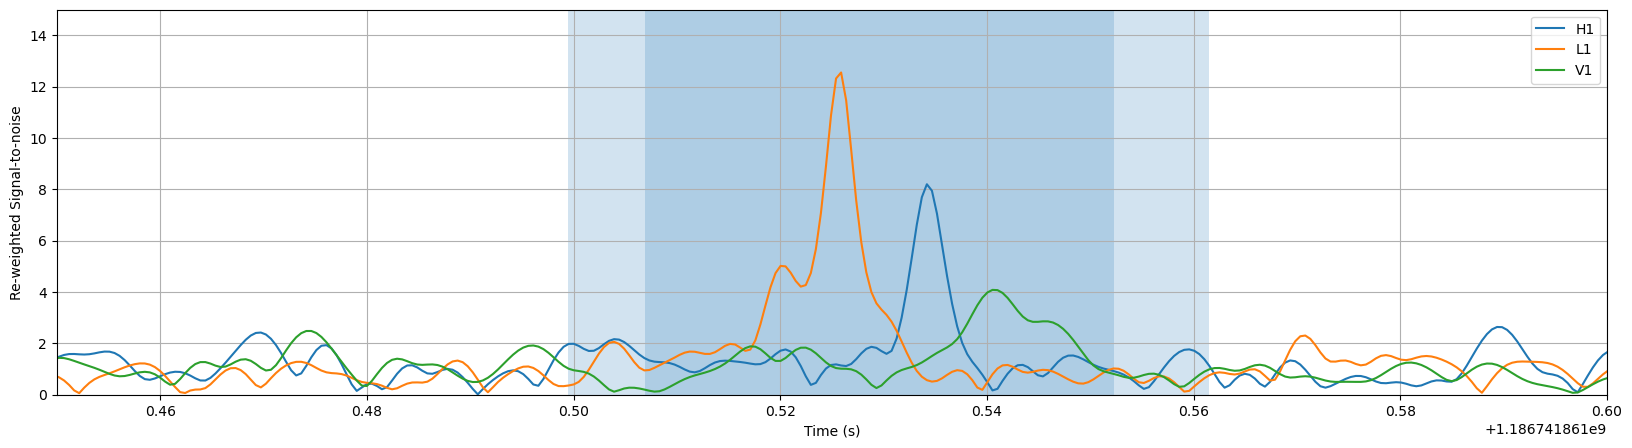

Virgo Peak has a statistic value of 4.084315817669038


In [13]:
import numpy
from pycbc.detector import Detector

# Calculate the "time of flight" between Virgo detector and each LIGO observatory
d = Detector("V1")

tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector('H1'))
tof['L1'] = d.light_travel_time_to_detector(Detector('L1'))

# Record the "time of peak" in the LIGO observatories
ptime = {}


pylab.figure(figsize = ((20, 5)))
for ifo in ifos:
    
    # Shade the region around each LIGO peak that could have a peak in Virgo if from an astrophysical source
    if ifo is not "V1":
        ptime[ifo] = snr[ifo].sample_times[nsnr[ifo].argmax()]
        pylab.axvspan(ptime[ifo] - tof[ifo], ptime[ifo] + tof[ifo], alpha = 0.2, lw = 10) # Shading region
        
    pylab.plot(snr[ifo].sample_times, nsnr[ifo], label = ifo)
    
# Calculate the "span of time" that a Virgo peak could in principle happen in from time of flight considerations
start = ptime['H1'] - tof['H1']
end = ptime['L1'] + tof['L1']

# Convert the times to indicate along with how large the region is in number of samples.
window_size = int((end - start) * snr['V1'].sample_rate)
sidx = int((start - snr['V1'].start_time) * snr['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value
onsource = nsnr['V1'][sidx:eidx].max()

pylab.legend()
pylab.grid()
pylab.xlim(m.time - .05, m.time + .10)
pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

print('Virgo Peak has a statistic value of {}'.format(onsource))

**In the plot above we see the re-weighted SNR time series.<br>On top of that we've shaded the regions which are consistent with Virgo signal based on the peaks in the LIGO observatories.<br>Only in the darker region, it is possible to have a peak in the SNR that is consistent with both LIGO observatories.**

In [18]:
# Now that we calculated the "on-source" peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our onsource and repeating the same peak finding (max) procedure

# Walk through the data in chunks and calculate the peak statistic value in each
peaks = []

i = 0
while i + window_size < len(nsnr['V1']):
    p = nsnr['V1'][i:i+window_size].max()
    peaks.append(p)
    
    i+=window_size
    
    # Skip pass the oncsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = numpy.array(peaks)

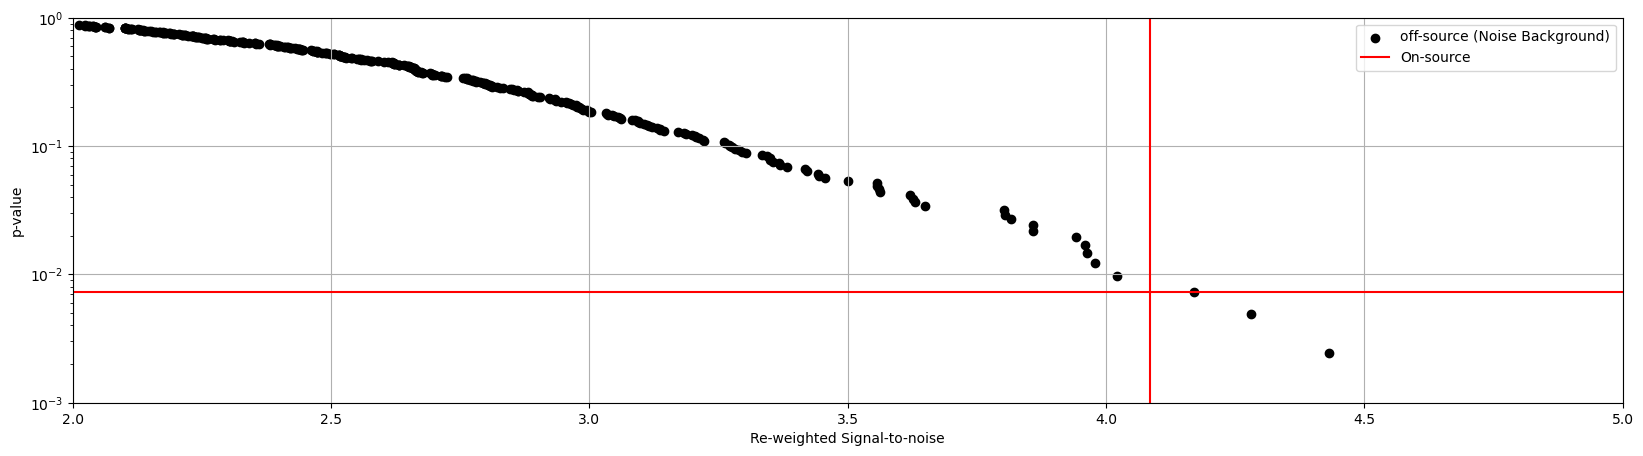

The p-value associated with the GW170814 peak is 0.007317073170731708


In [20]:
# The p-value is just the number of samples observed in the background with a value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background samples.
pcurve = numpy.arange(1, len(peaks) + 1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))
pylab.figure(figsize = (20, 5))
pylab.scatter(peaks, pcurve, label = "off-source (Noise Background)", color = "black")

pylab.axvline(onsource, label='On-source', color='red')
pylab.axhline(pvalue, color='red')

pylab.legend()
pylab.yscale('log')
pylab.grid()
pylab.ylim(1e-3, 1e0)
pylab.ylabel('p-value')
pylab.xlabel('Re-weighted Signal-to-noise')

pylab.xlim(2, 5)
pylab.show()

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

**We find a peak in Virgo as large as the observed one has an approximately 1% chance of occuring due to noise alone. Given the simplifications of this tutorial, we find a result in agreement with the "GW170814 discovery paper" which reported a p-value of 0.3%.**